In [1]:
from environments import OneDCleanupEnv, CleanupRegion
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from agents import QAgent
import torch

2023-12-04 23:40:04,179	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"cuda available: {torch.cuda.is_available()}")
np.set_printoptions(threshold=np.inf)

cuda available: False


In [3]:

steps_per_episode = 1000
num_agents = 10
agent_ids = [str(i) for i in range(num_agents)]

In [4]:
thresholdDepletion = 0.4
thresholdRestoration = 0.0
wasteSpawnProbability = 0.5
appleRespawnProbability = 0.05
dirt_multiplier = 10

area = 150

In [5]:
gamma = 0.999
epsilon = 1.0
epsilon_decay = 0.99995
epsilon_min = 0.1
lr = 0.0001
batch_size = 8

In [6]:
state_dim = 4
num_action_outputs = 1
action_size = 3

In [7]:
env = OneDCleanupEnv(agent_ids=agent_ids,
                     num_agents=num_agents,
                     area=area,
                     thresholdDepletion=thresholdDepletion,
                     thresholdRestoration=thresholdRestoration,
                     wasteSpawnProbability=wasteSpawnProbability,
                     appleRespawnProbability=appleRespawnProbability,
                     use_randomness=False,
                     dirt_multiplier=dirt_multiplier)
picker_q = QAgent(state_dim=state_dim,
                action_size=action_size,
                num_action_outputs=num_action_outputs,
                gamma=gamma,
                epsilon=epsilon,
                epsilon_decay=epsilon_decay,
                epsilon_min=epsilon_min,
                lr=lr,
                device=device,
                batch_size=batch_size,
                q_layers=[
                    (state_dim, 64),
                    (64, 64),
                    (64, action_size)
                ])
cleaner_q = QAgent(state_dim=state_dim,
                action_size=action_size,
                num_action_outputs=num_action_outputs,
                gamma=gamma,
                epsilon=epsilon,
                epsilon_decay=epsilon_decay,
                epsilon_min=epsilon_min,
                lr=lr,
                device=device,
                batch_size=batch_size,
                q_layers=[
                    (state_dim, 64),
                    (64, 64),
                    (64, action_size)
                ])

In [8]:
ending_ep_rewards = []
num_episodes = 100
steps_per_epsiode = 1000
verbose_episode = num_episodes - 1

In [9]:
max_reward = 0
for episode in range(num_episodes):
    print(f"========= Episode {episode} =========")

    states, info = env.reset()

    #print(f"info: {info}")

    for step in tqdm(range(steps_per_epsiode)):
        num_apples, num_dirt, _, _ = states["coordinator"]
        agent_frequency_in_dirt = num_dirt / (num_apples + num_dirt)
        num_cleaner = round(num_agents * agent_frequency_in_dirt)
        num_picker = num_agents - num_cleaner
        assignments = env.get_greedy_assignments(num_picker, num_cleaner)
        actions = {}
        for agent_id in agent_ids:
            if assignments[agent_id] == CleanupRegion.APPLE:
                actions[agent_id] = (assignments[agent_id], picker_q.act(np.array(states[agent_id])).flatten()[0] - 1)
            else:
                actions[agent_id] = (assignments[agent_id], cleaner_q.act(np.array(states[agent_id])).flatten()[0] - 1)
        #print(f"actions: {actions}")
        next_states, rewards, dones, _, info = env.step(actions)

        for agent_id in agent_ids:
            if assignments[agent_id] == CleanupRegion.APPLE:
                picker_q.step(np.array(states[agent_id]), actions[agent_id][1] + 1, rewards[agent_id], np.array(next_states[agent_id]))
            else:
                cleaner_q.step(np.array(states[agent_id]), actions[agent_id][1] + 1, rewards[agent_id], np.array(next_states[agent_id]))

        if episode > verbose_episode:
            print(f"========= Step {step} =========")
            print(f"info: {info}")

        states = next_states

        if dones["__all__"]:
            break 

    ending_reward = info["total_apple_consumed"]

    print(f"ending reward: {ending_reward}")
    print(f"========= End of Episode {episode} =========")

    ending_ep_rewards.append(ending_reward)

    picker_q.scheduler.step()
    cleaner_q.scheduler.step()

    if ending_reward > max_reward:
        max_reward = ending_reward

========= Episode 0 =========


  1%|          | 6/1000 [00:00<00:17, 57.66it/s]

100%|█████████▉| 999/1000 [00:09<00:00, 104.70it/s]


ending reward: 2109
========= End of Episode 0 =========
========= Episode 1 =========


100%|█████████▉| 999/1000 [00:09<00:00, 110.72it/s]


ending reward: 1517
========= End of Episode 1 =========
========= Episode 2 =========


100%|█████████▉| 999/1000 [00:11<00:00, 90.53it/s] 


ending reward: 1006
========= End of Episode 2 =========
========= Episode 3 =========


100%|█████████▉| 999/1000 [00:10<00:00, 99.82it/s] 


ending reward: 612
========= End of Episode 3 =========
========= Episode 4 =========


100%|█████████▉| 999/1000 [00:09<00:00, 101.64it/s]


ending reward: 554
========= End of Episode 4 =========
========= Episode 5 =========


100%|█████████▉| 999/1000 [00:08<00:00, 112.33it/s]


ending reward: 436
========= End of Episode 5 =========
========= Episode 6 =========


100%|█████████▉| 999/1000 [00:08<00:00, 111.02it/s]


ending reward: 437
========= End of Episode 6 =========
========= Episode 7 =========


100%|█████████▉| 999/1000 [00:10<00:00, 92.61it/s] 


ending reward: 463
========= End of Episode 7 =========
========= Episode 8 =========


100%|█████████▉| 999/1000 [00:09<00:00, 105.78it/s]


ending reward: 381
========= End of Episode 8 =========
========= Episode 9 =========


100%|█████████▉| 999/1000 [00:09<00:00, 107.18it/s]


ending reward: 347
========= End of Episode 9 =========
========= Episode 10 =========


100%|█████████▉| 999/1000 [00:09<00:00, 102.75it/s]


ending reward: 324
========= End of Episode 10 =========
========= Episode 11 =========


100%|█████████▉| 999/1000 [00:09<00:00, 105.28it/s]


ending reward: 356
========= End of Episode 11 =========
========= Episode 12 =========


100%|█████████▉| 999/1000 [00:08<00:00, 114.39it/s]


ending reward: 243
========= End of Episode 12 =========
========= Episode 13 =========


100%|█████████▉| 999/1000 [00:09<00:00, 106.55it/s]


ending reward: 340
========= End of Episode 13 =========
========= Episode 14 =========


100%|█████████▉| 999/1000 [00:08<00:00, 112.32it/s]


ending reward: 367
========= End of Episode 14 =========
========= Episode 15 =========


100%|█████████▉| 999/1000 [00:09<00:00, 105.17it/s]


ending reward: 474
========= End of Episode 15 =========
========= Episode 16 =========


100%|█████████▉| 999/1000 [00:08<00:00, 112.81it/s]


ending reward: 372
========= End of Episode 16 =========
========= Episode 17 =========


100%|█████████▉| 999/1000 [00:09<00:00, 110.80it/s]


ending reward: 386
========= End of Episode 17 =========
========= Episode 18 =========


100%|█████████▉| 999/1000 [00:08<00:00, 114.15it/s]


ending reward: 415
========= End of Episode 18 =========
========= Episode 19 =========


100%|█████████▉| 999/1000 [00:09<00:00, 110.58it/s]


ending reward: 495
========= End of Episode 19 =========
========= Episode 20 =========


100%|█████████▉| 999/1000 [00:09<00:00, 102.80it/s]


ending reward: 2888
========= End of Episode 20 =========
========= Episode 21 =========


100%|█████████▉| 999/1000 [00:09<00:00, 108.14it/s]


ending reward: 288
========= End of Episode 21 =========
========= Episode 22 =========


100%|█████████▉| 999/1000 [00:09<00:00, 110.91it/s]


ending reward: 395
========= End of Episode 22 =========
========= Episode 23 =========


100%|█████████▉| 999/1000 [00:08<00:00, 112.15it/s]


ending reward: 384
========= End of Episode 23 =========
========= Episode 24 =========


100%|█████████▉| 999/1000 [00:09<00:00, 106.44it/s]


ending reward: 337
========= End of Episode 24 =========
========= Episode 25 =========


100%|█████████▉| 999/1000 [00:09<00:00, 110.12it/s]


ending reward: 502
========= End of Episode 25 =========
========= Episode 26 =========


100%|█████████▉| 999/1000 [00:09<00:00, 101.63it/s]


ending reward: 1208
========= End of Episode 26 =========
========= Episode 27 =========


100%|█████████▉| 999/1000 [00:09<00:00, 109.21it/s]


ending reward: 455
========= End of Episode 27 =========
========= Episode 28 =========


100%|█████████▉| 999/1000 [00:09<00:00, 105.64it/s]


ending reward: 523
========= End of Episode 28 =========
========= Episode 29 =========


100%|█████████▉| 999/1000 [00:08<00:00, 113.97it/s]


ending reward: 280
========= End of Episode 29 =========
========= Episode 30 =========


100%|█████████▉| 999/1000 [00:08<00:00, 111.10it/s]


ending reward: 2871
========= End of Episode 30 =========
========= Episode 31 =========


100%|█████████▉| 999/1000 [00:09<00:00, 110.05it/s]


ending reward: 316
========= End of Episode 31 =========
========= Episode 32 =========


100%|█████████▉| 999/1000 [00:08<00:00, 113.04it/s]


ending reward: 240
========= End of Episode 32 =========
========= Episode 33 =========


100%|█████████▉| 999/1000 [00:09<00:00, 107.78it/s]


ending reward: 462
========= End of Episode 33 =========
========= Episode 34 =========


100%|█████████▉| 999/1000 [00:11<00:00, 88.12it/s] 


ending reward: 207
========= End of Episode 34 =========
========= Episode 35 =========


100%|█████████▉| 999/1000 [00:08<00:00, 114.64it/s]


ending reward: 385
========= End of Episode 35 =========
========= Episode 36 =========


100%|█████████▉| 999/1000 [00:32<00:00, 30.98it/s] 


ending reward: 400
========= End of Episode 36 =========
========= Episode 37 =========


100%|█████████▉| 999/1000 [01:17<00:00, 12.97it/s] 


ending reward: 2889
========= End of Episode 37 =========
========= Episode 38 =========


100%|█████████▉| 999/1000 [01:14<00:00, 13.36it/s] 


ending reward: 367
========= End of Episode 38 =========
========= Episode 39 =========


100%|█████████▉| 999/1000 [04:04<00:00,  4.09it/s]  


ending reward: 359
========= End of Episode 39 =========
========= Episode 40 =========


100%|█████████▉| 999/1000 [07:20<00:00,  2.27it/s] 


ending reward: 585
========= End of Episode 40 =========
========= Episode 41 =========


100%|█████████▉| 999/1000 [15:46<00:00,  1.06it/s] 


ending reward: 371
========= End of Episode 41 =========
========= Episode 42 =========


100%|█████████▉| 999/1000 [00:16<00:00, 59.70it/s]


ending reward: 325
========= End of Episode 42 =========
========= Episode 43 =========


100%|█████████▉| 999/1000 [00:13<00:00, 71.54it/s]


ending reward: 360
========= End of Episode 43 =========
========= Episode 44 =========


100%|█████████▉| 999/1000 [00:13<00:00, 75.35it/s]


ending reward: 306
========= End of Episode 44 =========
========= Episode 45 =========


100%|█████████▉| 999/1000 [00:11<00:00, 87.93it/s] 


ending reward: 456
========= End of Episode 45 =========
========= Episode 46 =========


100%|█████████▉| 999/1000 [00:10<00:00, 99.31it/s] 


ending reward: 2439
========= End of Episode 46 =========
========= Episode 47 =========


100%|█████████▉| 999/1000 [00:09<00:00, 104.15it/s]


ending reward: 424
========= End of Episode 47 =========
========= Episode 48 =========


100%|█████████▉| 999/1000 [00:09<00:00, 109.46it/s]


ending reward: 347
========= End of Episode 48 =========
========= Episode 49 =========


100%|█████████▉| 999/1000 [00:09<00:00, 104.85it/s]


ending reward: 341
========= End of Episode 49 =========
========= Episode 50 =========


100%|█████████▉| 999/1000 [00:09<00:00, 108.72it/s]


ending reward: 354
========= End of Episode 50 =========
========= Episode 51 =========


100%|█████████▉| 999/1000 [00:09<00:00, 104.05it/s]


ending reward: 392
========= End of Episode 51 =========
========= Episode 52 =========


100%|█████████▉| 999/1000 [00:09<00:00, 105.32it/s]


ending reward: 312
========= End of Episode 52 =========
========= Episode 53 =========


100%|█████████▉| 999/1000 [00:09<00:00, 105.30it/s]


ending reward: 391
========= End of Episode 53 =========
========= Episode 54 =========


100%|█████████▉| 999/1000 [00:09<00:00, 106.42it/s]


ending reward: 450
========= End of Episode 54 =========
========= Episode 55 =========


100%|█████████▉| 999/1000 [00:10<00:00, 97.95it/s] 


ending reward: 345
========= End of Episode 55 =========
========= Episode 56 =========


100%|█████████▉| 999/1000 [00:09<00:00, 110.14it/s]


ending reward: 380
========= End of Episode 56 =========
========= Episode 57 =========


100%|█████████▉| 999/1000 [00:09<00:00, 107.22it/s]


ending reward: 517
========= End of Episode 57 =========
========= Episode 58 =========


100%|█████████▉| 999/1000 [00:09<00:00, 103.96it/s]


ending reward: 443
========= End of Episode 58 =========
========= Episode 59 =========


100%|█████████▉| 999/1000 [00:09<00:00, 107.59it/s]


ending reward: 272
========= End of Episode 59 =========
========= Episode 60 =========


100%|█████████▉| 999/1000 [00:08<00:00, 111.45it/s]


ending reward: 403
========= End of Episode 60 =========
========= Episode 61 =========


100%|█████████▉| 999/1000 [00:09<00:00, 109.41it/s]


ending reward: 357
========= End of Episode 61 =========
========= Episode 62 =========


100%|█████████▉| 999/1000 [00:09<00:00, 109.26it/s]


ending reward: 381
========= End of Episode 62 =========
========= Episode 63 =========


100%|█████████▉| 999/1000 [00:09<00:00, 107.22it/s]


ending reward: 326
========= End of Episode 63 =========
========= Episode 64 =========


100%|█████████▉| 999/1000 [00:09<00:00, 106.52it/s]


ending reward: 338
========= End of Episode 64 =========
========= Episode 65 =========


100%|█████████▉| 999/1000 [00:09<00:00, 105.80it/s]


ending reward: 385
========= End of Episode 65 =========
========= Episode 66 =========


100%|█████████▉| 999/1000 [00:09<00:00, 103.39it/s]


ending reward: 399
========= End of Episode 66 =========
========= Episode 67 =========


100%|█████████▉| 999/1000 [00:09<00:00, 103.84it/s]


ending reward: 419
========= End of Episode 67 =========
========= Episode 68 =========


100%|█████████▉| 999/1000 [00:09<00:00, 108.32it/s]


ending reward: 461
========= End of Episode 68 =========
========= Episode 69 =========


100%|█████████▉| 999/1000 [00:09<00:00, 109.84it/s]


ending reward: 397
========= End of Episode 69 =========
========= Episode 70 =========


100%|█████████▉| 999/1000 [00:08<00:00, 111.02it/s]


ending reward: 216
========= End of Episode 70 =========
========= Episode 71 =========


100%|█████████▉| 999/1000 [00:09<00:00, 106.38it/s]


ending reward: 362
========= End of Episode 71 =========
========= Episode 72 =========


100%|█████████▉| 999/1000 [00:09<00:00, 105.66it/s]


ending reward: 335
========= End of Episode 72 =========
========= Episode 73 =========


100%|█████████▉| 999/1000 [00:10<00:00, 93.14it/s] 


ending reward: 2891
========= End of Episode 73 =========
========= Episode 74 =========


100%|█████████▉| 999/1000 [00:09<00:00, 103.50it/s]


ending reward: 330
========= End of Episode 74 =========
========= Episode 75 =========


100%|█████████▉| 999/1000 [00:10<00:00, 99.69it/s] 


ending reward: 332
========= End of Episode 75 =========
========= Episode 76 =========


100%|█████████▉| 999/1000 [00:09<00:00, 104.10it/s]


ending reward: 348
========= End of Episode 76 =========
========= Episode 77 =========


100%|█████████▉| 999/1000 [00:09<00:00, 104.77it/s]


ending reward: 362
========= End of Episode 77 =========
========= Episode 78 =========


100%|█████████▉| 999/1000 [00:09<00:00, 105.27it/s]


ending reward: 385
========= End of Episode 78 =========
========= Episode 79 =========


100%|█████████▉| 999/1000 [00:09<00:00, 104.60it/s]


ending reward: 366
========= End of Episode 79 =========
========= Episode 80 =========


100%|█████████▉| 999/1000 [00:09<00:00, 104.81it/s]


ending reward: 405
========= End of Episode 80 =========
========= Episode 81 =========


100%|█████████▉| 999/1000 [00:08<00:00, 111.27it/s]


ending reward: 2881
========= End of Episode 81 =========
========= Episode 82 =========


100%|█████████▉| 999/1000 [00:08<00:00, 115.10it/s]


ending reward: 420
========= End of Episode 82 =========
========= Episode 83 =========


100%|█████████▉| 999/1000 [00:09<00:00, 104.66it/s]


ending reward: 371
========= End of Episode 83 =========
========= Episode 84 =========


100%|█████████▉| 999/1000 [00:09<00:00, 109.94it/s]


ending reward: 2890
========= End of Episode 84 =========
========= Episode 85 =========


100%|█████████▉| 999/1000 [00:08<00:00, 113.62it/s]


ending reward: 403
========= End of Episode 85 =========
========= Episode 86 =========


100%|█████████▉| 999/1000 [00:08<00:00, 112.39it/s]


ending reward: 315
========= End of Episode 86 =========
========= Episode 87 =========


100%|█████████▉| 999/1000 [00:09<00:00, 101.03it/s]


ending reward: 335
========= End of Episode 87 =========
========= Episode 88 =========


100%|█████████▉| 999/1000 [00:09<00:00, 108.43it/s]


ending reward: 530
========= End of Episode 88 =========
========= Episode 89 =========


100%|█████████▉| 999/1000 [00:09<00:00, 110.05it/s]


ending reward: 458
========= End of Episode 89 =========
========= Episode 90 =========


100%|█████████▉| 999/1000 [00:09<00:00, 103.91it/s]


ending reward: 389
========= End of Episode 90 =========
========= Episode 91 =========


100%|█████████▉| 999/1000 [00:09<00:00, 109.62it/s]


ending reward: 385
========= End of Episode 91 =========
========= Episode 92 =========


100%|█████████▉| 999/1000 [00:08<00:00, 113.46it/s]


ending reward: 604
========= End of Episode 92 =========
========= Episode 93 =========


100%|█████████▉| 999/1000 [00:08<00:00, 112.95it/s]


ending reward: 365
========= End of Episode 93 =========
========= Episode 94 =========


100%|█████████▉| 999/1000 [00:08<00:00, 112.07it/s]


ending reward: 544
========= End of Episode 94 =========
========= Episode 95 =========


100%|█████████▉| 999/1000 [00:09<00:00, 110.65it/s]


ending reward: 428
========= End of Episode 95 =========
========= Episode 96 =========


100%|█████████▉| 999/1000 [00:09<00:00, 107.57it/s]


ending reward: 349
========= End of Episode 96 =========
========= Episode 97 =========


100%|█████████▉| 999/1000 [00:09<00:00, 109.47it/s]


ending reward: 2877
========= End of Episode 97 =========
========= Episode 98 =========


100%|█████████▉| 999/1000 [00:08<00:00, 114.05it/s]


ending reward: 440
========= End of Episode 98 =========
========= Episode 99 =========


100%|█████████▉| 999/1000 [00:08<00:00, 114.64it/s]

ending reward: 322
========= End of Episode 99 =========


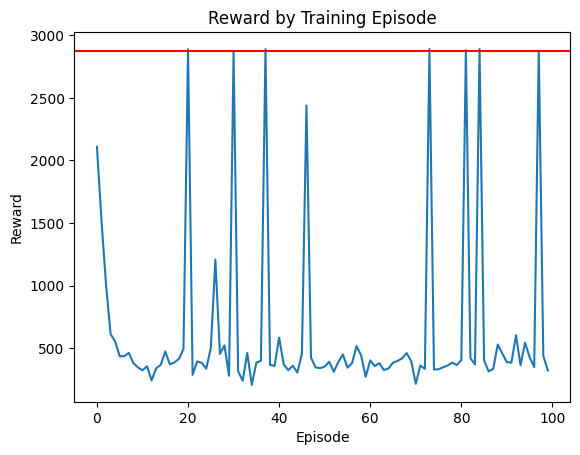

In [17]:
plt.title("Reward by Training Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(ending_ep_rewards)
plt.axhline(y=2875.1, color='r', linestyle='-')
plt.show()

In [10]:
num_episodes = 20
verbose_episode = num_episodes - 1
test_stats = []
picker_q.q_network.eval()
cleaner_q.q_network.eval()
for episode in range(num_episodes):
    test_stats.append({
        "num_apples": [],
        "num_dirt": [],
        "pickers": [],
        "cleaners": [],
        "total_reward": 0,
    })
    
    print(f"========= Episode {episode} =========")

    states, info = env.reset()
    test_stats[-1]["num_apples"].append(info["apple"])
    test_stats[-1]["num_dirt"].append(info["dirt"])
    test_stats[-1]["pickers"].append(info["picker"])
    test_stats[-1]["cleaners"].append(info["cleaner"])

    #print(f"info: {info}")

    for step in tqdm(range(steps_per_episode)):
        num_apples, num_dirt, _, _ = states["coordinator"]
        agent_frequency_in_dirt = num_dirt / (num_apples + num_dirt)
        num_cleaner = round(num_agents * agent_frequency_in_dirt)
        num_picker = num_agents - num_cleaner
        assignments = env.get_greedy_assignments(num_picker, num_cleaner)

        actions = {}
        for agent_id in agent_ids:
            if assignments[agent_id] == CleanupRegion.APPLE:
                actions[agent_id] = (assignments[agent_id], picker_q.act(np.array(states[agent_id])).flatten()[0] - 1)
            else:
                actions[agent_id] = (assignments[agent_id], cleaner_q.act(np.array(states[agent_id])).flatten()[0] - 1)
        next_states, reward, dones, _, info = env.step(actions)
        
        test_stats[-1]["num_apples"].append(info["apple"])
        test_stats[-1]["num_dirt"].append(info["dirt"])
        test_stats[-1]["pickers"].append(info["picker"])
        test_stats[-1]["cleaners"].append(info["cleaner"])

        states = next_states

        if episode > verbose_episode:
            print(f"========= Step {step} =========")
            print(f"info: {info}")

        if dones["__all__"]:
            break 

    ending_reward = info["total_apple_consumed"]

    test_stats[-1]["total_reward"] = ending_reward

    print(f"ending reward: {ending_reward}")
    #print(f"reward graph: {reward_graph}")
    print(f"========= End of Episode {episode} =========")



========= Episode 0 =========


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|█████████▉| 999/1000 [00:00<00:00, 1427.24it/s]


ending reward: 326
========= End of Episode 0 =========
========= Episode 1 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1476.74it/s]


ending reward: 459
========= End of Episode 1 =========
========= Episode 2 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1493.10it/s]


ending reward: 370
========= End of Episode 2 =========
========= Episode 3 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1468.33it/s]


ending reward: 349
========= End of Episode 3 =========
========= Episode 4 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1493.61it/s]


ending reward: 252
========= End of Episode 4 =========
========= Episode 5 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1437.40it/s]


ending reward: 313
========= End of Episode 5 =========
========= Episode 6 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1479.75it/s]


ending reward: 400
========= End of Episode 6 =========
========= Episode 7 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1523.78it/s]


ending reward: 2878
========= End of Episode 7 =========
========= Episode 8 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1382.16it/s]


ending reward: 451
========= End of Episode 8 =========
========= Episode 9 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1530.37it/s]


ending reward: 431
========= End of Episode 9 =========
========= Episode 10 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1511.75it/s]


ending reward: 377
========= End of Episode 10 =========
========= Episode 11 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1123.89it/s]


ending reward: 381
========= End of Episode 11 =========
========= Episode 12 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1471.89it/s]


ending reward: 385
========= End of Episode 12 =========
========= Episode 13 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1508.11it/s]


ending reward: 310
========= End of Episode 13 =========
========= Episode 14 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1435.26it/s]


ending reward: 492
========= End of Episode 14 =========
========= Episode 15 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1526.49it/s]


ending reward: 2872
========= End of Episode 15 =========
========= Episode 16 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1517.40it/s]


ending reward: 277
========= End of Episode 16 =========
========= Episode 17 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1390.33it/s]


ending reward: 371
========= End of Episode 17 =========
========= Episode 18 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1494.39it/s]


ending reward: 333
========= End of Episode 18 =========
========= Episode 19 =========


100%|█████████▉| 999/1000 [00:00<00:00, 1493.13it/s]

ending reward: 369
========= End of Episode 19 =========


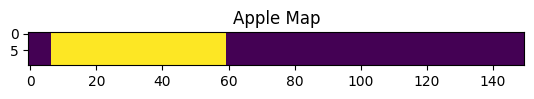

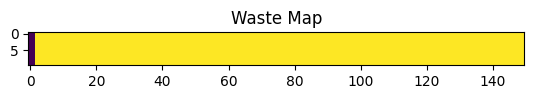

/Users/gabeguralnick/git/social_reinforcement_learning/environments/one_d_cleanup_env.py:474: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  apple_agent_map[np.where(apple_agent_map == id)] = 1


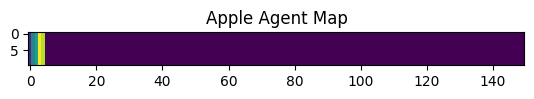

/Users/gabeguralnick/git/social_reinforcement_learning/environments/one_d_cleanup_env.py:484: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  waste_agent_map[np.where(waste_agent_map == id)] = 1


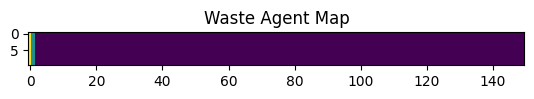

In [11]:
env.render()

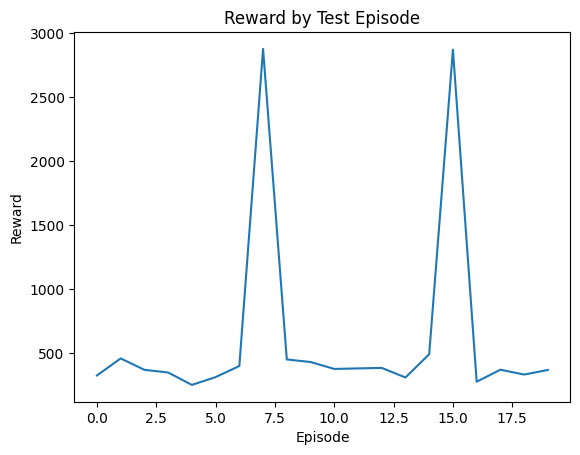

Average reward: 619.8


In [12]:
plt.figure()
plt.title("Reward by Test Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot([stat['total_reward'] for stat in test_stats])
plt.show()
print(f"Average reward: {np.mean([stat['total_reward'] for stat in test_stats])}")

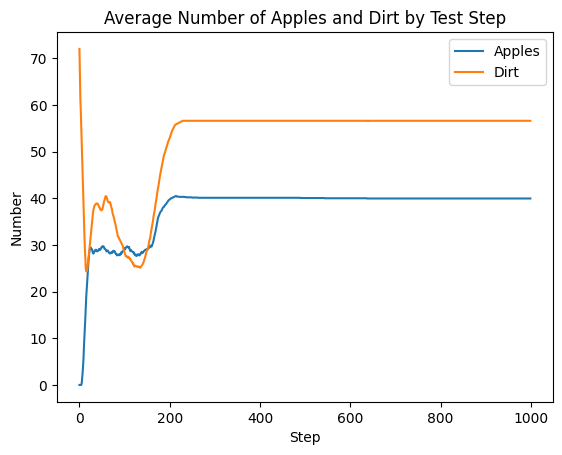

In [13]:
plt.figure()
plt.title("Average Number of Apples and Dirt by Test Step")
plt.xlabel("Step")
plt.ylabel("Number")
avg_num_apples = []
avg_num_dirt = []
for i in range(steps_per_episode):
    avg_num_apples.append(np.mean([stat['num_apples'][i] for stat in test_stats]))
    avg_num_dirt.append(np.mean([stat['num_dirt'][i] for stat in test_stats]))
plt.plot(avg_num_apples, label="Apples")
plt.plot(avg_num_dirt, label="Dirt")
plt.legend()
plt.show()

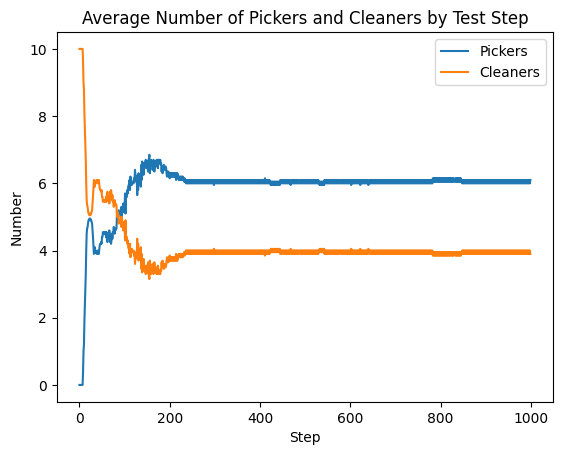

In [14]:
plt.figure()
plt.title("Average Number of Pickers and Cleaners by Test Step")
plt.xlabel("Step")
plt.ylabel("Number")
avg_num_pickers = []
avg_num_cleaners = []
for i in range(steps_per_episode):
    avg_num_pickers.append(np.mean([stat['pickers'][i] for stat in test_stats]))
    avg_num_cleaners.append(np.mean([stat['cleaners'][i] for stat in test_stats]))
plt.plot(avg_num_pickers, label="Pickers")
plt.plot(avg_num_cleaners, label="Cleaners")
plt.legend()
plt.show()

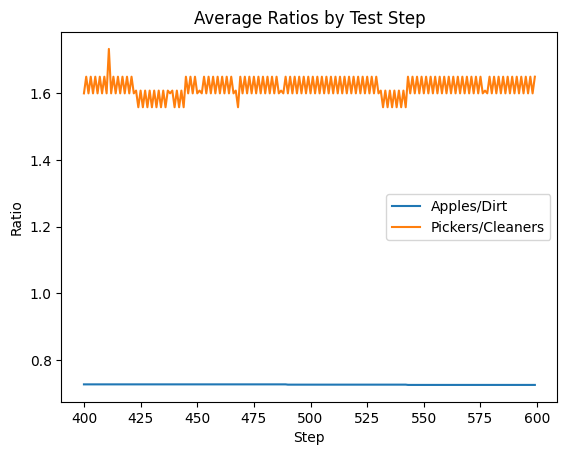

In [15]:
plt.figure()
plt.title("Average Ratios by Test Step")
plt.xlabel("Step")
plt.ylabel("Ratio")
avg_apple_dirt_ratios = []
apple_dirt_steps = []
avg_picker_cleaner_ratios = []
picker_cleaner_steps = []
for i in range(steps_per_episode):
    #avg_apple_dirt_ratios.append(np.mean([stat['num_apples'][i] / (stat['num_dirt'][i] + 1e-8) for stat in test_stats]))
    #avg_picker_cleaner_ratios.append(np.mean([stat['pickers'][i] / (stat['cleaners'][i]) for stat in test_stats if stat['cleaners'][i] > 0]))
    apple_dirt = []
    picker_cleaner = []
    for stat in test_stats:
        if stat['num_dirt'][i] > 0:
            apple_dirt.append(stat['num_apples'][i] / stat['num_dirt'][i])
        if stat['cleaners'][i] > 0:
            picker_cleaner.append(stat['pickers'][i] / stat['cleaners'][i])
    if len(apple_dirt) > 0:
        avg_apple_dirt_ratios.append(np.mean(apple_dirt))
        apple_dirt_steps.append(i)
    if len(picker_cleaner) > 0:
        avg_picker_cleaner_ratios.append(np.mean(picker_cleaner))
        picker_cleaner_steps.append(i)

plt.plot(apple_dirt_steps[400:600], avg_apple_dirt_ratios[400:600], label="Apples/Dirt")
plt.plot(picker_cleaner_steps[400:600], avg_picker_cleaner_ratios[400:600], label="Pickers/Cleaners")
plt.legend()
plt.show()

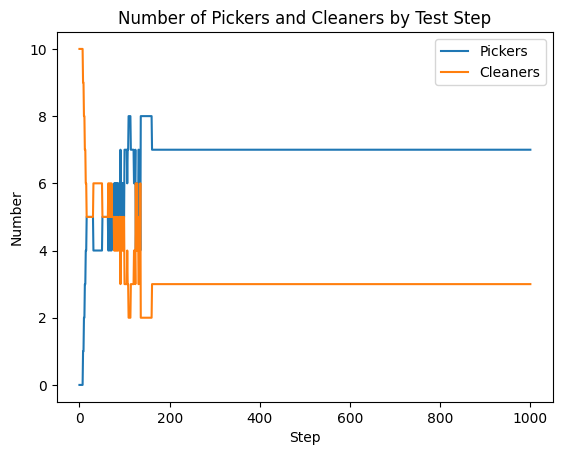

In [16]:
plt.figure()
plt.title("Number of Pickers and Cleaners by Test Step")
plt.xlabel("Step")
plt.ylabel("Number")
episode = test_stats[0]
plt.plot(episode['pickers'], label="Pickers")
plt.plot(episode['cleaners'], label="Cleaners")
plt.legend()
plt.show()